# Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import time 

import os
import librosa
import librosa.display

import matplotlib.pyplot as plt
import seaborn as sns

import mlflow


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Lectura del dataset

In [3]:
urbansound8k_path = "../../data/raw/UrbanSound8K/"

# Primer dataset - Carpeta con los audios
urbansound8k_audio_path = "audio/"

# Segundo dataset - Archivo CSV con metadatos sobre los audios
urbansound8k_metadata_path_file = "metadata/UrbanSound8K.csv" 


mfcc_n_coeficiente = "20"

# Dataset input
dataset_input_path = f"../../data/processed/dataset_mfcc_{mfcc_n_coeficiente}.csv"

# Lectura
dataset_urbansound8k_df = pd.read_csv(dataset_input_path, sep=";")
dataset_urbansound8k_df.head(3)


,fold,classID,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,...,delta2_mfcc_var_11,delta2_mfcc_var_12,delta2_mfcc_var_13,delta2_mfcc_var_14,delta2_mfcc_var_15,delta2_mfcc_var_16,delta2_mfcc_var_17,delta2_mfcc_var_18,delta2_mfcc_var_19,delta2_mfcc_var_20
0,5,3,-275.91843,119.49280,-98.21178,-66.515140,-42.606050,0.505066,-28.330938,-5.746867,...,41.223183,27.885939,51.33420,47.697777,49.812220,14.355281,46.313560,44.401760,110.738230,25.753720
1,5,2,-500.90840,185.10641,-86.53282,49.858850,9.230822,22.548956,-3.567175,12.220052,...,38.453808,28.922888,32.19454,32.540830,27.270597,28.516123,27.197691,23.052114,32.825718,28.952673
2,5,2,-531.19530,186.93994,-70.34916,40.429245,9.121047,18.398588,6.283282,15.504061,...,25.948908,28.198223,31.85179,33.908460,27.358440,25.454557,29.894941,28.242071,25.876347,25.493631


In [4]:
print(f"Cantidad de columnas: {dataset_urbansound8k_df.shape[1]}")
print(f"Cantidad de filas: {dataset_urbansound8k_df.shape[0]}")

print("Columnas del dataset:")
contador = 0
for name in dataset_urbansound8k_df.columns:
    contador +=1
    if contador%5==0:
        print("")        
    print(f"'{name}'", end=", ")

Cantidad de columnas: 222
Cantidad de filas: 8732
Columnas del dataset:
'fold', 'classID', 'mfcc_mean_1', 'mfcc_mean_2', 
'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 
'mfcc_mean_8', 'mfcc_mean_9', 'mfcc_mean_10', 'mfcc_mean_11', 'mfcc_mean_12', 
'mfcc_mean_13', 'mfcc_mean_14', 'mfcc_mean_15', 'mfcc_mean_16', 'mfcc_mean_17', 
'mfcc_mean_18', 'mfcc_mean_19', 'mfcc_mean_20', 'mfcc_median_1', 'mfcc_median_2', 
'mfcc_median_3', 'mfcc_median_4', 'mfcc_median_5', 'mfcc_median_6', 'mfcc_median_7', 
'mfcc_median_8', 'mfcc_median_9', 'mfcc_median_10', 'mfcc_median_11', 'mfcc_median_12', 
'mfcc_median_13', 'mfcc_median_14', 'mfcc_median_15', 'mfcc_median_16', 'mfcc_median_17', 
'mfcc_median_18', 'mfcc_median_19', 'mfcc_median_20', 'mfcc_min_1', 'mfcc_min_2', 
'mfcc_min_3', 'mfcc_min_4', 'mfcc_min_5', 'mfcc_min_6', 'mfcc_min_7', 
'mfcc_min_8', 'mfcc_min_9', 'mfcc_min_10', 'mfcc_min_11', 'mfcc_min_12', 
'mfcc_min_13', 'mfcc_min_14', 'mfcc_min_15', 'mfcc_min_16', 'mfcc

# Generación datos de entrenamiento y prueba

In [4]:
# Separar las características y la variable objetivo
# ['tasa_cruce_cero', 'entropia_espectograma', 'avg_centroide_espectral'
columnas_caracteristicas_mfcc = [col for col in dataset_urbansound8k_df.columns if 'mfcc' in col]
columna_predecir = 'classID'
columna_fold = 'fold'

# Separar las características y etiquetas
X_caracteristicas = dataset_urbansound8k_df[columnas_caracteristicas_mfcc]  # 'classID' es la etiqueta y 'fold' el número de fold
y = dataset_urbansound8k_df[columna_predecir]
folds = dataset_urbansound8k_df['fold']

# Modelos de Clasificacion

In [5]:
# Iniciar el experimento en MLflow
mlflow.set_experiment(f"FINAL MFCC{mfcc_n_coeficiente} - V1")

<Experiment: artifact_location='file:///c:/Users/colbe/Documents/VIU/TFM/tfm-clasificador-fuentes-sonoras-ciudad/notebooks/modelado/mlruns/215287537433083468', creation_time=1730608206357, experiment_id='215287537433083468', last_update_time=1730608206357, lifecycle_stage='active', name='FINAL MFCC20 - V1', tags={}>

## KNeighborsClassifier

Fold 1 Accuracy: 0.5304
Tiempo de entrenamiento (segundos): 0.0081
Fold 2 Accuracy: 0.5766
Tiempo de entrenamiento (segundos): 0.0147
Fold 3 Accuracy: 0.5200
Tiempo de entrenamiento (segundos): 0.0016
Fold 4 Accuracy: 0.6303
Tiempo de entrenamiento (segundos): 0.0000
Fold 5 Accuracy: 0.6442
Tiempo de entrenamiento (segundos): 0.0000
Fold 6 Accuracy: 0.5832
Tiempo de entrenamiento (segundos): 0.0000
Fold 7 Accuracy: 0.5382
Tiempo de entrenamiento (segundos): 0.0000
Fold 8 Accuracy: 0.5335
Tiempo de entrenamiento (segundos): 0.0171
Fold 9 Accuracy: 0.6605
Tiempo de entrenamiento (segundos): 0.0123
Fold 10 Accuracy: 0.6045
Tiempo de entrenamiento (segundos): 0.0157

Accuracy promedio: 0.5821
Desviación estándar: 0.0487
Tiempo de entrenamiento promedio (segundos): 0.0070


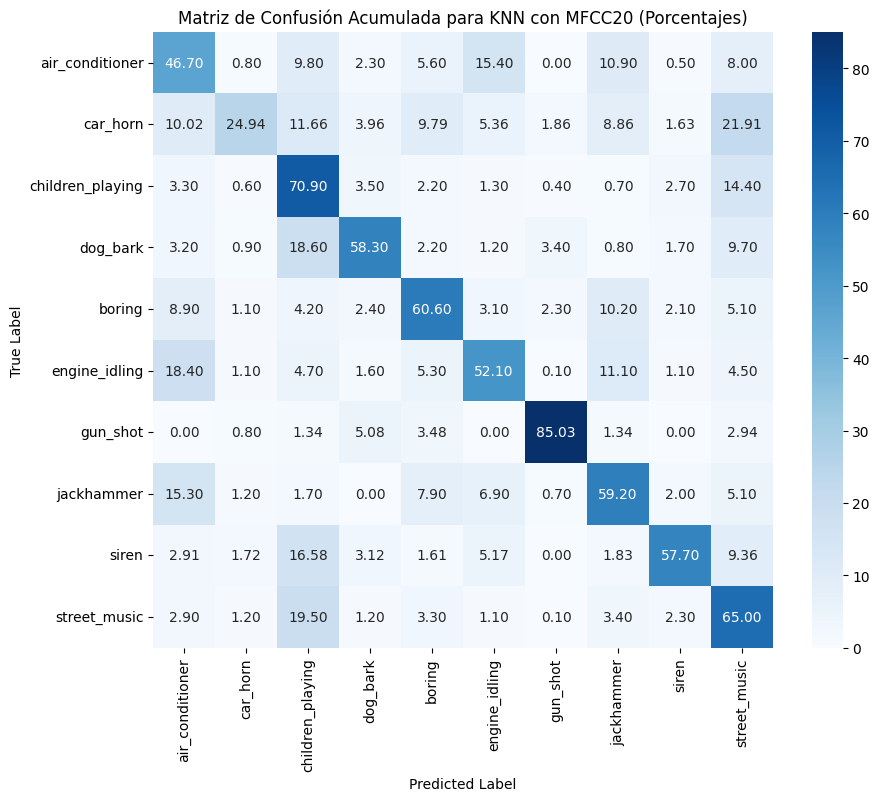

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import time
import numpy as np
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns

# Definir el modelo KNN con parámetros fijos
knn = KNeighborsClassifier(n_neighbors=9, weights='uniform', metric='manhattan')

# Inicializar listas para almacenar accuracies, tiempos de entrenamiento y etiquetas
fold_accuracies = []
fold_training_times = []
all_y_true = []
all_y_pred = []

# Etiquetas de las clases
class_labels = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "boring", 
                "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

# Realizar la validación cruzada respetando los folds predefinidos
for fold in range(1, 11):  # Hay 10 folds en UrbanSound8K
    # Dividir el dataset en entrenamiento y prueba
    train_index = folds != fold
    test_index = folds == fold
    
    X_train, X_test = X_caracteristicas[train_index], X_caracteristicas[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Medir el tiempo de entrenamiento
    start_time = time.time()

    # Entrenar el modelo con los parámetros fijos
    knn.fit(X_train, y_train)

    # Tiempo de finalización
    end_time = time.time()

    # Calcular el tiempo de entrenamiento
    training_time = end_time - start_time
    fold_training_times.append(training_time)

    # Predecir y evaluar
    y_pred = knn.predict(X_test)
    accuracy_val = accuracy_score(y_test, y_pred)
    f1_val = f1_score(y_test, y_pred, average='weighted')
    precision_val = precision_score(y_test, y_pred, average='weighted')
    recall_val = recall_score(y_test, y_pred, average='weighted')
    fold_accuracies.append(accuracy_val)

    # Acumular las predicciones y etiquetas verdaderas para la matriz de confusión final
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    print(f"Fold {fold} Accuracy: {accuracy_val:.4f}")
    print(f"Tiempo de entrenamiento (segundos): {training_time:.4f}")

    with mlflow.start_run(run_name=f"KNN FINAL MFCC{mfcc_n_coeficiente} Fold_{fold}") as run:
        # Registrar los parámetros y métricas en MLflow
        mlflow.log_params({
            "n_neighbors": 9,
            "weights": 'uniform',
            "metric": 'manhattan',
            "mfcc_coeficiente": mfcc_n_coeficiente,
            "fold": fold,
            "cv": "Fixed",
            "model": "KNN"
        })

        # Registrar las métricas de este fold
        mlflow.log_metric("accuracy_score", accuracy_val)
        mlflow.log_metric("f1_weighted_score", f1_val)
        mlflow.log_metric("precision_weighted_score", precision_val)
        mlflow.log_metric("recall_weighted_score", recall_val)

        # Registrar el tiempo de entrenamiento
        mlflow.log_metric("training_time_seconds", training_time)

# Mostrar el promedio y desviación estándar
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_training_time = np.mean(fold_training_times)

print(f"\nAccuracy promedio: {mean_accuracy:.4f}")
print(f"Desviación estándar: {std_accuracy:.4f}")
print(f"Tiempo de entrenamiento promedio (segundos): {mean_training_time:.4f}")

# Generar la matriz de confusión acumulada
conf_matrix = confusion_matrix(all_y_true, all_y_pred)

conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Visualizar la matriz de confusión con valores porcentuales y etiquetas de clase
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Matriz de Confusión Acumulada para KNN con MFCC{mfcc_n_coeficiente} (Porcentajes)")
plt.show()


## Random Forest

Fold 1 Accuracy: 0.7148
Tiempo de entrenamiento (segundos): 53.7331
Fold 2 Accuracy: 0.7309
Tiempo de entrenamiento (segundos): 52.1173
Fold 3 Accuracy: 0.5903
Tiempo de entrenamiento (segundos): 52.6864
Fold 4 Accuracy: 0.6869
Tiempo de entrenamiento (segundos): 52.0900
Fold 5 Accuracy: 0.7650
Tiempo de entrenamiento (segundos): 60.6963
Fold 6 Accuracy: 0.6853
Tiempo de entrenamiento (segundos): 66.7243
Fold 7 Accuracy: 0.6897
Tiempo de entrenamiento (segundos): 66.4418
Fold 8 Accuracy: 0.7258
Tiempo de entrenamiento (segundos): 64.3437
Fold 9 Accuracy: 0.7230
Tiempo de entrenamiento (segundos): 61.2786
Fold 10 Accuracy: 0.7575
Tiempo de entrenamiento (segundos): 62.3449

Accuracy promedio: 0.7069
Desviación estándar: 0.0468
Tiempo de entrenamiento promedio (segundos): 59.2456


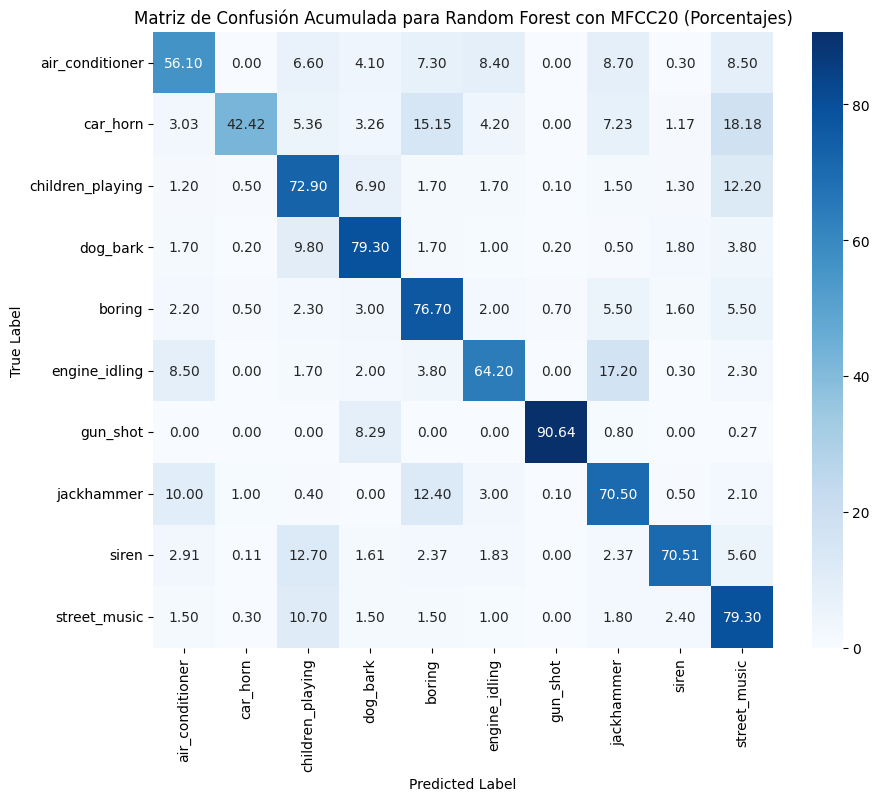

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import time
import numpy as np
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns

# Definir el modelo Random Forest con parámetros fijos
rf = RandomForestClassifier(
    n_estimators=500, 
    max_depth=50, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    max_features='log2', 
    bootstrap=False,
    random_state=42
)

# Inicializar listas para almacenar accuracies, tiempos de entrenamiento y etiquetas
fold_accuracies = []
fold_training_times = []
all_y_true = []
all_y_pred = []

# Etiquetas de las clases
class_labels = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "boring", 
                "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

# Realizar la validación cruzada respetando los folds predefinidos
for fold in range(1, 11):  # Hay 10 folds en UrbanSound8K
    # Dividir el dataset en entrenamiento y prueba
    train_index = folds != fold
    test_index = folds == fold
    
    X_train, X_test = X_caracteristicas[train_index], X_caracteristicas[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Medir el tiempo de entrenamiento
    start_time = time.time()

    # Entrenar el modelo con los parámetros fijos
    rf.fit(X_train, y_train)

    # Tiempo de finalización
    end_time = time.time()

    # Calcular el tiempo de entrenamiento
    training_time = end_time - start_time
    fold_training_times.append(training_time)

    # Predecir y evaluar
    y_pred = rf.predict(X_test)
    accuracy_val = accuracy_score(y_test, y_pred)
    f1_val = f1_score(y_test, y_pred, average='weighted')
    precision_val = precision_score(y_test, y_pred, average='weighted')
    recall_val = recall_score(y_test, y_pred, average='weighted')

    fold_accuracies.append(accuracy_val)

    # Acumular las predicciones y etiquetas verdaderas para la matriz de confusión final
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    print(f"Fold {fold} Accuracy: {accuracy_val:.4f}")
    print(f"Tiempo de entrenamiento (segundos): {training_time:.4f}")

    # Registro en MLflow
    with mlflow.start_run(run_name=f"RF Fixed MFCC{mfcc_n_coeficiente} Fold_{fold}") as run:
        # Registrar los parámetros y métricas en MLflow
        mlflow.log_params({
            "n_estimators": 500,
            "max_depth": 50,
            "min_samples_split": 2,
            "min_samples_leaf": 1,
            "max_features": 'log2',
            "bootstrap": False,
            "mfcc_coeficiente": mfcc_n_coeficiente,
            "fold": fold,
            "cv": "Fixed",
            "model": "RF"
        })

        # Registrar las métricas de este fold
        mlflow.log_metric("accuracy_score", accuracy_val)
        mlflow.log_metric("f1_weighted_score", f1_val)
        mlflow.log_metric("precision_weighted_score", precision_val)
        mlflow.log_metric("recall_weighted_score", recall_val)

        # Registrar el tiempo de entrenamiento
        mlflow.log_metric("training_time_seconds", training_time)

# Mostrar el promedio y desviación estándar
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_training_time = np.mean(fold_training_times)

print(f"\nAccuracy promedio: {mean_accuracy:.4f}")
print(f"Desviación estándar: {std_accuracy:.4f}")
print(f"Tiempo de entrenamiento promedio (segundos): {mean_training_time:.4f}")

# Generar la matriz de confusión acumulada
conf_matrix = confusion_matrix(all_y_true, all_y_pred)

conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Visualizar la matriz de confusión con valores porcentuales y etiquetas de clase
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Matriz de Confusión Acumulada para Random Forest con MFCC{mfcc_n_coeficiente} (Porcentajes)")
plt.show()


## SVM

Fold 1 Accuracy: 0.6254
Tiempo de entrenamiento (segundos): 56.9707
Fold 2 Accuracy: 0.6273
Tiempo de entrenamiento (segundos): 51.7151
Fold 3 Accuracy: 0.5816
Tiempo de entrenamiento (segundos): 47.8333
Fold 4 Accuracy: 0.6687
Tiempo de entrenamiento (segundos): 42.2906
Fold 5 Accuracy: 0.7051
Tiempo de entrenamiento (segundos): 54.4889
Fold 6 Accuracy: 0.6780
Tiempo de entrenamiento (segundos): 50.3595
Fold 7 Accuracy: 0.7136
Tiempo de entrenamiento (segundos): 53.6052
Fold 8 Accuracy: 0.6563
Tiempo de entrenamiento (segundos): 56.3343
Fold 9 Accuracy: 0.7267
Tiempo de entrenamiento (segundos): 51.7938
Fold 10 Accuracy: 0.6619
Tiempo de entrenamiento (segundos): 58.8984

Accuracy promedio: 0.6645
Desviación estándar: 0.0424
Tiempo de entrenamiento promedio (segundos): 52.4290


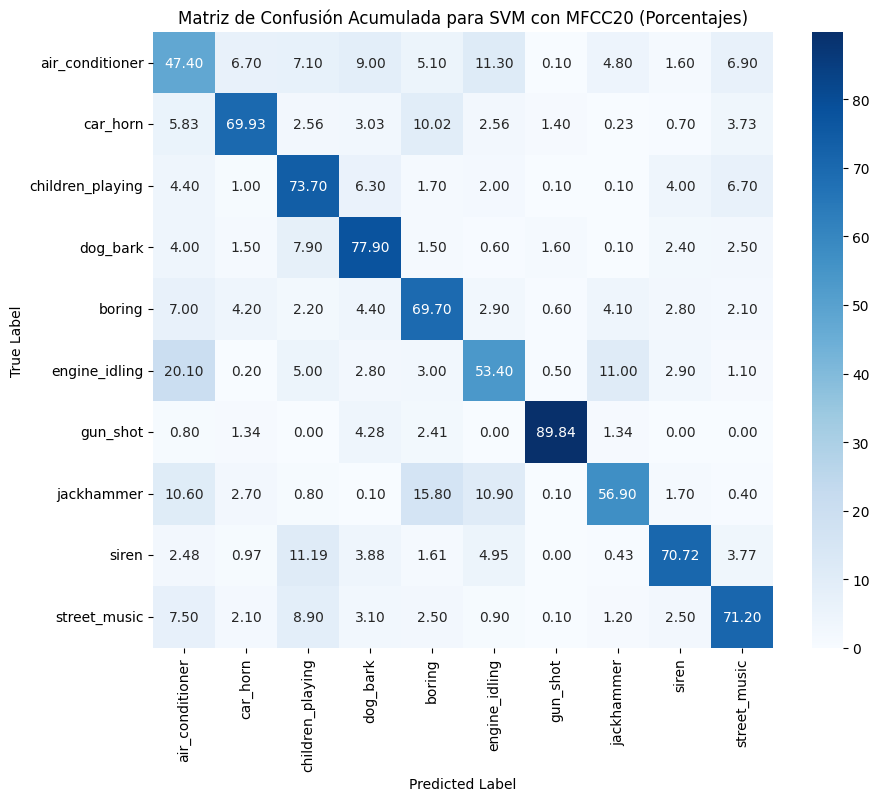

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import time
import numpy as np
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns

# Definir el modelo SVM con parámetros fijos
svm = SVC(C=0.001, kernel='linear', random_state=42)

# Inicializar listas para almacenar accuracies, tiempos de entrenamiento y etiquetas
fold_accuracies = []
fold_training_times = []
all_y_true = []
all_y_pred = []

# Etiquetas de las clases
class_labels = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "boring", 
                "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

# Realizar la validación cruzada respetando los folds predefinidos
for fold in range(1, 11):  # Hay 10 folds en UrbanSound8K
    # Dividir el dataset en entrenamiento y prueba
    train_index = folds != fold
    test_index = folds == fold
    
    X_train, X_test = X_caracteristicas[train_index], X_caracteristicas[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Medir el tiempo de entrenamiento
    start_time = time.time()

    # Entrenar el modelo con los parámetros fijos
    svm.fit(X_train, y_train)

    # Tiempo de finalización
    end_time = time.time()

    # Calcular el tiempo de entrenamiento
    training_time = end_time - start_time
    fold_training_times.append(training_time)

    # Predecir y evaluar
    y_pred = svm.predict(X_test)
    accuracy_val = accuracy_score(y_test, y_pred)
    f1_val = f1_score(y_test, y_pred, average='weighted')
    precision_val = precision_score(y_test, y_pred, average='weighted')
    recall_val = recall_score(y_test, y_pred, average='weighted')
    fold_accuracies.append(accuracy_val)

    # Acumular las predicciones y etiquetas verdaderas para la matriz de confusión final
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    print(f"Fold {fold} Accuracy: {accuracy_val:.4f}")
    print(f"Tiempo de entrenamiento (segundos): {training_time:.4f}")

    # Registro en MLflow
    with mlflow.start_run(run_name=f"SVM Fixed MFCC{mfcc_n_coeficiente} Fold_{fold}") as run:
        # Registrar los parámetros y métricas en MLflow
        mlflow.log_params({
            "C": 0.0001,
            "kernel": 'linear',
            "mfcc_coeficiente": mfcc_n_coeficiente,
            "fold": fold,
            "cv": "Fixed",
            "model": "SVM"
        })

        # Registrar las métricas de este fold
        mlflow.log_metric("accuracy_score", accuracy_val)
        mlflow.log_metric("f1_weighted_score", f1_val)
        mlflow.log_metric("precision_weighted_score", precision_val)
        mlflow.log_metric("recall_weighted_score", recall_val)

        # Registrar el tiempo de entrenamiento
        mlflow.log_metric("training_time_seconds", training_time)

# Mostrar el promedio y desviación estándar
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_training_time = np.mean(fold_training_times)

print(f"\nAccuracy promedio: {mean_accuracy:.4f}")
print(f"Desviación estándar: {std_accuracy:.4f}")
print(f"Tiempo de entrenamiento promedio (segundos): {mean_training_time:.4f}")

# Generar la matriz de confusión acumulada
conf_matrix = confusion_matrix(all_y_true, all_y_pred)

conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Visualizar la matriz de confusión con valores porcentuales y etiquetas de clase
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Matriz de Confusión Acumulada para SVM con MFCC{mfcc_n_coeficiente} (Porcentajes)")
plt.show()

# Grafico de comparacion

C:\Users\colbe\AppData\Local\Temp\ipykernel_344\388596318.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Modelo', y='Accuracy', data=df[df['MFCC'] == mfcc], palette='Set2')


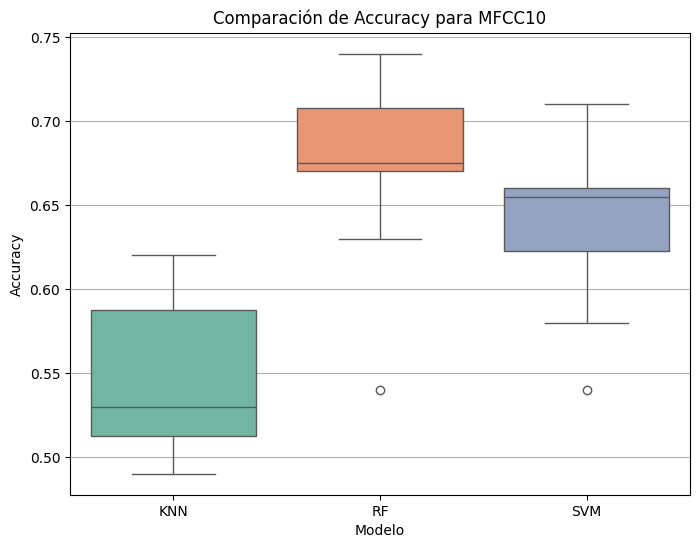

C:\Users\colbe\AppData\Local\Temp\ipykernel_344\388596318.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Modelo', y='Accuracy', data=df[df['MFCC'] == mfcc], palette='Set2')


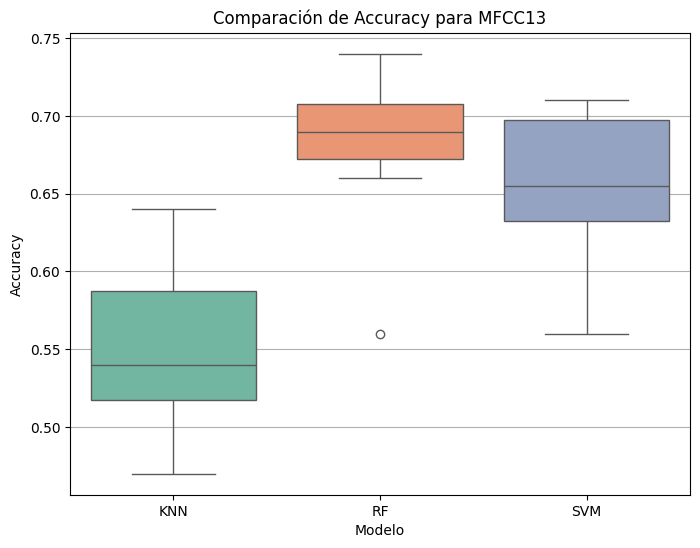

C:\Users\colbe\AppData\Local\Temp\ipykernel_344\388596318.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Modelo', y='Accuracy', data=df[df['MFCC'] == mfcc], palette='Set2')


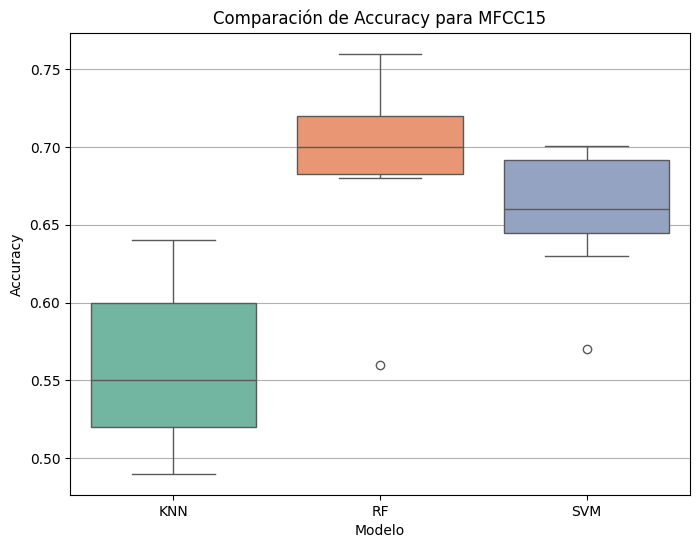

C:\Users\colbe\AppData\Local\Temp\ipykernel_344\388596318.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Modelo', y='Accuracy', data=df[df['MFCC'] == mfcc], palette='Set2')


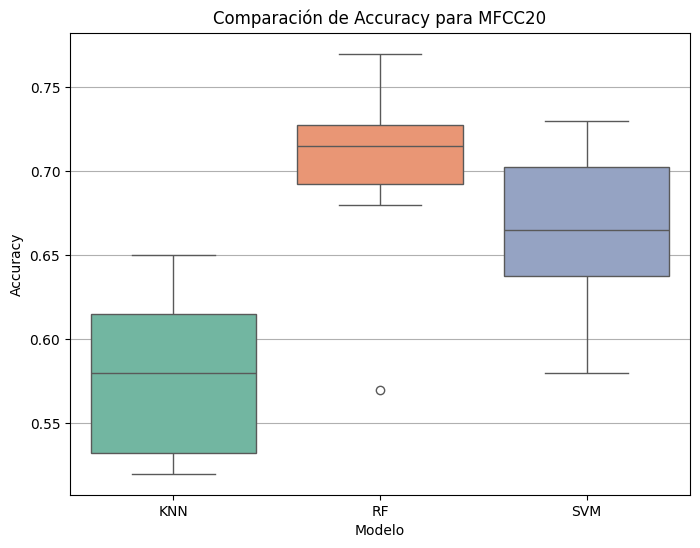

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Paso 1: Organizar tus datos en un DataFrame

# Crear una lista con los nombres de los folds
folds = ['FOLD1', 'FOLD2', 'FOLD3', 'FOLD4', 'FOLD5', 'FOLD6', 'FOLD7', 'FOLD8', 'FOLD9', 'FOLD10']

# Datos de exactitud para cada modelo y configuración de MFCC
data = {
    'FOLD': folds * 12,  # 10 folds para cada combinación de modelo y MFCC (10 folds x 12 combinaciones)
    'MFCC': ['MFCC10'] * 30 + ['MFCC13'] * 30 + ['MFCC15'] * 30 + ['MFCC20'] * 30,
    'Modelo': (['KNN'] * 10 + ['RF'] * 10 + ['SVM'] * 10) * 4,
    'Accuracy': [
        # MFCC10 - KNN
        0.51, 0.53, 0.49, 0.58, 0.62, 0.52, 0.50, 0.53, 0.62, 0.59,
        # MFCC10 - RF
        0.67, 0.63, 0.54, 0.72, 0.71, 0.67, 0.68, 0.67, 0.70, 0.74,
        # MFCC10 - SVM
        0.62, 0.58, 0.54, 0.66, 0.66, 0.65, 0.71, 0.71, 0.66, 0.63,
        # MFCC13 - KNN
        0.51, 0.54, 0.47, 0.59, 0.64, 0.54, 0.51, 0.54, 0.64, 0.58,
        # MFCC13 - RF
        0.68, 0.66, 0.56, 0.70, 0.71, 0.69, 0.69, 0.67, 0.71, 0.74,
        # MFCC13 - SVM
        0.64, 0.62, 0.56, 0.63, 0.66, 0.66, 0.71, 0.71, 0.71, 0.65,
        # MFCC15 - KNN
        0.51, 0.55, 0.49, 0.60, 0.64, 0.55, 0.52, 0.52, 0.64, 0.60,
        # MFCC15 - RF
        0.69, 0.68, 0.56, 0.72, 0.74, 0.68, 0.69, 0.72, 0.71, 0.76,
        # MFCC15 - SVM
        0.66, 0.63, 0.57, 0.66, 0.66, 0.673, 0.698, 0.699, 0.701, 0.64,
        # MFCC20 - KNN
        0.53, 0.57, 0.52, 0.62, 0.65, 0.59, 0.54, 0.53, 0.65, 0.60,
        # MFCC20 - RF
        0.71, 0.72, 0.57, 0.70, 0.76, 0.69, 0.68, 0.73, 0.72, 0.77,
        # MFCC20 - SVM
        0.63, 0.63, 0.58, 0.67, 0.71, 0.68, 0.71, 0.66, 0.73, 0.66
    ]
}

# Crear el DataFrame
df = pd.DataFrame(data)

# Ajustar la columna 'Modelo' para que se repita correctamente
models = ['KNN'] * 10 + ['RF'] * 10 + ['SVM'] * 10
df['Modelo'] = models * 4  # Multiplicar por 4 porque hay 4 configuraciones de MFCC

# Paso 2: Crear un DataFrame separado para cada MFCC y generar los boxplots

mfcc_list = ['MFCC10', 'MFCC13', 'MFCC15', 'MFCC20']

for mfcc in mfcc_list:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Modelo', y='Accuracy', data=df[df['MFCC'] == mfcc], palette='Set2')
    plt.title(f'Comparación de Accuracy para {mfcc}')
    plt.ylabel('Accuracy')
    plt.xlabel('Modelo')
    plt.grid(axis='y')
    plt.show()


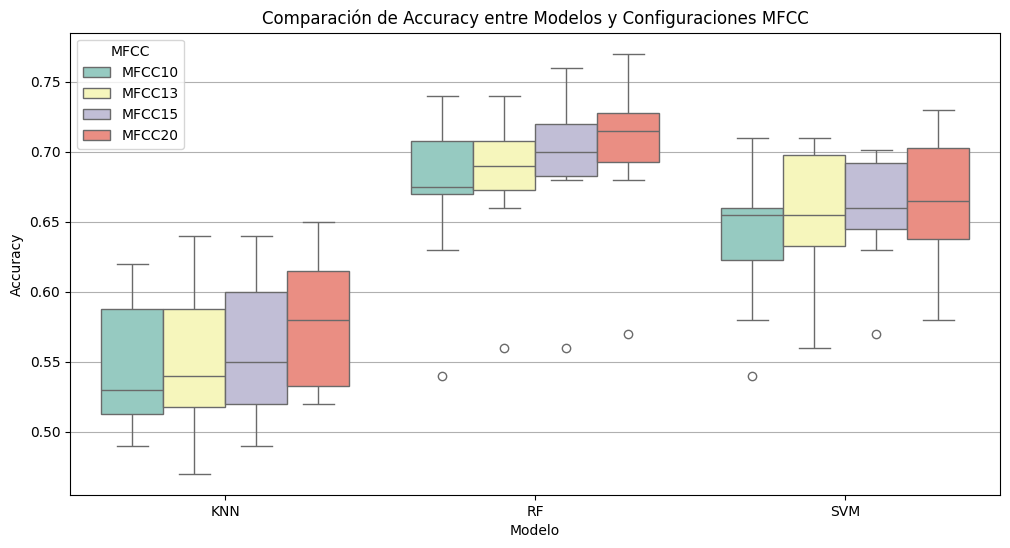

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Modelo', y='Accuracy', hue='MFCC', data=df, palette='Set3')
plt.title('Comparación de Accuracy entre Modelos y Configuraciones MFCC')
plt.ylabel('Accuracy')
plt.xlabel('Modelo')
plt.legend(title='MFCC')
plt.grid(axis='y')
plt.show()
